<a href="https://colab.research.google.com/github/knariksahakyan/fairAI/blob/main/preprocessing_durham_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting data for the city of Durham, North Caroline

In [ ]:

#Data for the city of Durham, Tennessee (will use this later for state of vehicle registration)CURRENT_STATE = 'NC'

#Getting the dataset from the Stanford website and unzipping it

!wget -O nc_durham_old.csv.zip https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_nc_durham_2020_04_01.csv.zip
!unzip nc_durham_old.csv.zip
!rm -r nc_durham_old.csv.zip


--2023-07-23 08:37:10--  https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_nc_durham_2020_04_01.csv.zip
Resolving stacks.stanford.edu (stacks.stanford.edu)... 171.67.37.91
Connecting to stacks.stanford.edu (stacks.stanford.edu)|171.67.37.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5273864 (5.0M) [application/zip]
Saving to: ‘nc_durham_old.csv.zip’

nc_durham_old.csv.z 100%[===================>]   5.03M   872KB/s    in 7.1s    

2023-07-23 08:37:18 (720 KB/s) - ‘nc_durham_old.csv.zip’ saved [5273864/5273864]

Archive:  nc_durham_old.csv.zip
  inflating: nc_durham_2020_04_01.csv  


In [ ]:
!pip install holidays
!pip install --upgrade fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)

from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

Reading dataset into pandas

In [ ]:
df_durham_old = pd.read_csv("nc_durham_2020_04_01.csv")

In [ ]:
df_durham_old.subject_race.value_counts()

black                     180851
white                      97415
hispanic                   38968
asian/pacific islander      4935
unknown                     2591
other                       1263
Name: subject_race, dtype: int64

In [ ]:
df_durham_old.raw_Race.value_counts()

B    181573
W    131637
U      6519
A      4973
I      1321
Name: raw_Race, dtype: int64

In [ ]:
df_durham_old.search_conducted.value_counts()

False    304318
True      21706
Name: search_conducted, dtype: int64

In [ ]:
df_durham_old.frisk_performed.value_counts()

False    325250
True        774
Name: frisk_performed, dtype: int64

In [ ]:
df_durham_old[df_durham_old.frisk_performed == True].search_conducted.value_counts()

True    774
Name: search_conducted, dtype: int64

Search conducted includes also frisk (if frisk is true then search is also true)

In [ ]:
# variables to be used for search
df_durham_old.search_basis.value_counts()

consent           11171
probable cause     5669
other              4092
Name: search_basis, dtype: int64

In [ ]:
df_durham_old.columns

Index(['raw_row_number', 'date', 'time', 'location', 'county_name',
       'subject_age', 'subject_race', 'subject_sex', 'officer_id_hash',
       'department_name', 'type', 'arrest_made', 'citation_issued',
       'warning_issued', 'outcome', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'frisk_performed', 'search_conducted',
       'search_person', 'search_vehicle', 'search_basis', 'reason_for_frisk',
       'reason_for_search', 'reason_for_stop', 'raw_Ethnicity', 'raw_Race',
       'raw_action_description'],
      dtype='object')

No Action Taken is nan in outcome

In [ ]:
df_durham_old.raw_action_description.value_counts()


Citation Issued    168351
Verbal Warning     111467
Written Warning     27751
No Action Taken     10782
On-View Arrest       7673
Name: raw_action_description, dtype: int64

In [ ]:
df_durham_old[df_durham_old.raw_action_description == 'Verbal Warning'].outcome.value_counts()

warning    111467
Name: outcome, dtype: int64

In [ ]:
df_durham_old[df_durham_old.raw_action_description == 'No Action Taken'].outcome.isnull().sum()

10782

In [ ]:
df_durham_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326024 entries, 0 to 326023
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   raw_row_number          326024 non-null  int64  
 1   date                    326024 non-null  object 
 2   time                    277785 non-null  object 
 3   location                326024 non-null  object 
 4   county_name             326024 non-null  object 
 5   subject_age             326017 non-null  float64
 6   subject_race            326023 non-null  object 
 7   subject_sex             326023 non-null  object 
 8   officer_id_hash         326024 non-null  object 
 9   department_name         326024 non-null  object 
 10  type                    326024 non-null  object 
 11  arrest_made             326024 non-null  bool   
 12  citation_issued         326024 non-null  bool   
 13  warning_issued          326024 non-null  bool   
 14  outcome             

In [ ]:
df_durham_old.shape

(326024, 29)

In [ ]:
df_durham_old.head(5).transpose()

,0,1,2,3,4
raw_row_number,1219541,1221117,1221124,1221133,1221146
date,2001-12-28,2002-01-02,2002-01-02,2002-01-02,2002-01-02
time,NaN,04:00:00,NaN,19:50:00,20:45:00
location,"Durham, Durham County","Durham, Durham County","Durham, Durham County","Durham, Durham County","Durham, Durham County"
county_name,Durham County,Durham County,Durham County,Durham County,Durham County
subject_age,22.0,28.0,21.0,28.0,36.0
subject_race,black,hispanic,black,black,black
subject_sex,female,male,male,female,female
officer_id_hash,5b9908c1a5,0c140e68b5,0c140e68b5,41b05be9b1,41b05be9b1
department_name,Durham Police Department,Durham Police Department,Durham Police Department,Durham Police Department,Durham Police Department


In [ ]:
df_durham_old["raw_action_description"].value_counts()

Citation Issued    168351
Verbal Warning     111467
Written Warning     27751
No Action Taken     10782
On-View Arrest       7673
Name: raw_action_description, dtype: int64

In [ ]:
df_durham_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326024 entries, 0 to 326023
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   raw_row_number          326024 non-null  int64  
 1   date                    326024 non-null  object 
 2   time                    277785 non-null  object 
 3   location                326024 non-null  object 
 4   county_name             326024 non-null  object 
 5   subject_age             326017 non-null  float64
 6   subject_race            326023 non-null  object 
 7   subject_sex             326023 non-null  object 
 8   officer_id_hash         326024 non-null  object 
 9   department_name         326024 non-null  object 
 10  type                    326024 non-null  object 
 11  arrest_made             326024 non-null  bool   
 12  citation_issued         326024 non-null  bool   
 13  warning_issued          326024 non-null  bool   
 14  outcome             

In [ ]:
df_durham_old["contraband_drugs"].value_counts()

False    18615
True      3091
Name: contraband_drugs, dtype: int64

In [ ]:
df_durham_old["reason_for_stop"].value_counts()

Speed Limit Violation            108640
Vehicle Regulatory Violation      67409
Vehicle Equipment Violation       43267
Investigation                     25226
Safe Movement Violation           25113
Stop Light/Sign Violation         22647
Other Motor Vehicle Violation     15383
Seat Belt Violation               11311
Checkpoint                         5098
Driving While Impaired             1930
Name: reason_for_stop, dtype: int64

In [ ]:
df_durham_old.type.value_counts()

vehicular    326024
Name: type, dtype: int64

In [ ]:
df_durham_old.outcome.value_counts()

citation    168351
warning     139218
arrest        7673
Name: outcome, dtype: int64

In [ ]:
df_durham_old.raw_action_description.value_counts()

Citation Issued    168351
Verbal Warning     111467
Written Warning     27751
No Action Taken     10782
On-View Arrest       7673
Name: raw_action_description, dtype: int64

## Transforming columns

In [ ]:
# transform date and time columns
# format date/time
df_durham_old['date_format']=pd.to_datetime(df_durham_old['date'], format='%Y-%m-%d')
df_durham_old["time_format"]= pd.to_datetime(df_durham_old.time, format='%H:%M:%S').dt.time
df_durham_old['hour'] = pd.to_datetime(df_durham_old.time, format='%H:%M:%S').dt.hour

In [ ]:
# creating new columns from date columns
import holidays
us_holidays = holidays.country_holidays('US')
holidays = df_durham_old['date_format'].apply(lambda x: us_holidays.get(x))
df_durham_old['holiday'] = holidays

df_durham_old['month'] = df_durham_old['date_format'].dt.month
df_durham_old['day_of_week'] = df_durham_old['date_format'].dt.day_of_week
df_durham_old['year'] = df_durham_old['date_format'].dt.year

# bin time
df_durham_old['time_of_day'] = pd.cut(df_durham_old['hour'],
                    bins=list(range(0,26,4)),
                    labels=['0-4','5-8','9-12','13-16','17-20','21-24'])

In [ ]:
# bin age
age_list = [1,16,24,35,45,55,65,100]
age_labels = ['under16','16to24','25to35','from36to45','from46to55', 'from56to65','from66tto100']
df_durham_old['bin_age'] = pd.cut(df_durham_old['subject_age'],
                    bins=age_list,
                    labels=age_labels)

In [ ]:
# map the variable to True | False | Not-searched
list_of_searched_variables = ['contraband_found', 'contraband_drugs', 'contraband_weapons']

search_mapping = {False:"False", True:"True", np.nan:"Not-searched"}

for col in list_of_searched_variables:
  df_durham_old[col] = df_durham_old[col].map(search_mapping)

df_durham_old.reason_for_search = df_durham_old.reason_for_search.fillna("Not-searched");

In [ ]:
def find_unique_values_in_columns(column_name, delimiter='|'):
  column_list = column_name.unique()
  all_elements_list = set()
  for str_el in column_list:
    if str(str_el) != 'nan':
      elements = str_el.split(delimiter)
      for el in elements:
        all_elements_list.add(el)
  return all_elements_list

In [ ]:
# separate frisk reasons into different columns
prefix = 'reason_for_frisk_'
column_name = df_durham_old.reason_for_frisk
all_reasons = find_unique_values_in_columns(column_name)
for column in list(all_reasons):
  df_durham_old[prefix+column] = column_name.str.contains(column)
  df_durham_old[prefix+column].fillna(False, inplace=True)

In [ ]:
# separate search reasons into different columns
prefix = 'reason_for_search_'
column_name = df_durham_old.reason_for_search
all_reasons = find_unique_values_in_columns(column_name)
for column in list(all_reasons):
  df_durham_old[prefix+column] = column_name.str.contains(column)
  df_durham_old[prefix+column].fillna(False, inplace=True)

In [ ]:
df_durham_old.head().transpose()

,0,1,2,3,4
raw_row_number,1219541,1221117,1221124,1221133,1221146
date,2001-12-28,2002-01-02,2002-01-02,2002-01-02,2002-01-02
time,NaN,04:00:00,NaN,19:50:00,20:45:00
location,"Durham, Durham County","Durham, Durham County","Durham, Durham County","Durham, Durham County","Durham, Durham County"
county_name,Durham County,Durham County,Durham County,Durham County,Durham County
subject_age,22.0,28.0,21.0,28.0,36.0
subject_race,black,hispanic,black,black,black
subject_sex,female,male,male,female,female
officer_id_hash,5b9908c1a5,0c140e68b5,0c140e68b5,41b05be9b1,41b05be9b1
department_name,Durham Police Department,Durham Police Department,Durham Police Department,Durham Police Department,Durham Police Department


In [ ]:
delete_columns = ['raw_row_number', 'date', 'time', 'location', 'officer_id_hash', 'subject_age',
       'type', 'reason_for_frisk', 'reason_for_search', 'raw_Ethnicity', 'raw_Race',
       'raw_action_description', 'county', 'date_format', 'time_format',
       'hour']

In [ ]:
df_durham_old.drop(columns = delete_columns, axis=1, inplace=True, errors='ignore')

# Training the initial model

## Model type

We will use a logistic regression model.

## Prepare training and test datasets

 our target variable is outcome(citation, arrest - 1, warning - 0), and our sensitive feature for the purposes of fairness assessment is race(black~white).

In [ ]:
# Disadvantages group A = 1, and privileged group A = 0
disadvantaged_group = 'black'
privileged_group = 'white'
df_durham_old.subject_race = df_durham_old.subject_race.map({disadvantaged_group: 1, privileged_group: 0})

In [ ]:
df_durham_old.subject_race.value_counts()

1.0    180851
0.0     97415
Name: subject_race, dtype: int64

In [ ]:
df_durham_old.outcome.unique()

array(['warning', 'citation', nan, 'arrest'], dtype=object)

In [ ]:
fined = ['citation', 'arrest']
desired_outcome = 1
undesired_outcome = 0
df_durham_old['target'] = np.where(df_durham_old.outcome.isin(fined), undesired_outcome, desired_outcome)

In [ ]:
df_durham_old['target'].value_counts()

0    176024
1    150000
Name: target, dtype: int64

In [ ]:
target_variable = "target"
demographic = ["subject_race", "subject_sex_female"]
sensitive = ["subject_race"]

In [ ]:
Y, A = df_durham_old.loc[:, target_variable], df_durham_old.loc[:, sensitive]

In [ ]:
dummy_columns = ['county_name', 'subject_race', 'subject_sex',
       'department_name', 'search_basis',
       'reason_for_stop', 'month', 'day_of_week', 'bin_age',
       'holiday', 'year', 'time_of_day', 'contraband_found', 'contraband_drugs', 'contraband_weapons']
X = pd.get_dummies(df_durham_old, columns=dummy_columns, drop_first=True)

In [ ]:
X.head()

,arrest_made,citation_issued,warning_issued,outcome,frisk_performed,search_conducted,search_person,search_vehicle,reason_for_frisk_Other Official Information,reason_for_frisk_Informant Tip,...,time_of_day_9-12,time_of_day_13-16,time_of_day_17-20,time_of_day_21-24,contraband_found_Not-searched,contraband_found_True,contraband_drugs_Not-searched,contraband_drugs_True,contraband_weapons_Not-searched,contraband_weapons_True
0,False,False,True,warning,False,False,False,False,False,False,...,0,0,0,0,1,0,1,0,1,0
1,False,True,False,citation,False,False,False,False,False,False,...,0,0,0,0,1,0,1,0,1,0
2,False,False,True,warning,False,False,False,False,False,False,...,0,0,0,0,1,0,1,0,1,0
3,False,True,False,citation,False,False,False,False,False,False,...,0,0,1,0,1,0,1,0,1,0
4,False,False,True,warning,False,False,False,False,False,False,...,0,0,1,0,1,0,1,0,1,0


In [ ]:
outcome_columns = ['outcome', 'arrest_made', 'citation_issued', 'warning_issued', 'target']

X.drop(columns=outcome_columns, inplace=True, errors='ignore')

In [ ]:
speeding = X['reason_for_stop_Speed Limit Violation'] == True
X_speed = X[speeding]
Y_speed = Y[speeding]
df_durham_old_speed = df_durham_old[speeding]
A_speed = A[speeding]

In [ ]:
Y.shape

(326024,)

In [ ]:
A.shape

(326024, 1)

In [ ]:
df_durham_old.shape

(326024, 37)

We split our data into a training and test portion.

In [ ]:
random_seed = 445
np.random.seed(random_seed)

X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df_durham_old,
    test_size=0.30,
    stratify=Y,
    random_state=random_seed
)

In [ ]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

In [ ]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

## Train the model

We train a logistic regression model

In [ ]:
unmitigated_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

In [ ]:
unmitigated_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

In [ ]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

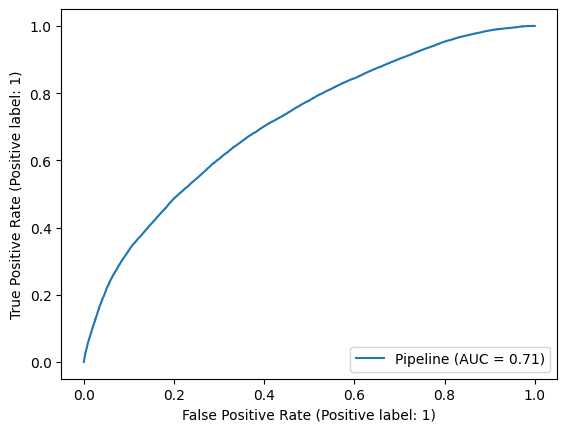

In [ ]:
RocCurveDisplay.from_estimator(unmitigated_pipeline, X_test, Y_test);

In [ ]:
#
saga_log_reg = LogisticRegression(max_iter=5000, solver='saga')
steps = [
    ("imputer", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ("preprocessing", StandardScaler()),
    ("logistic_regression", saga_log_reg)]
reg_pipeline = Pipeline(steps)



In [ ]:
reg_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('preprocessing', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(max_iter=5000, solver='saga'))])

In [ ]:
Y_pred_proba = reg_pipeline.predict_proba(X_test)[:,1]
Y_pred = reg_pipeline.predict(X_test)

Check model performance on test data.

In [ ]:
balanced_accuracy_score(Y_test, Y_pred)

0.6499158242017202

In [ ]:
X_train.head().transpose()

,144288,220260,13941,244917,302014
frisk_performed,False,False,False,False,False
search_conducted,False,False,False,False,False
search_person,False,False,False,False,False
search_vehicle,False,False,False,False,False
reason_for_frisk_Other Official Information,False,False,False,False,False
...,...,...,...,...,...
contraband_found_True,0,0,0,0,0
contraband_drugs_Not-searched,1,1,1,1,1
contraband_drugs_True,0,0,0,0,0
contraband_weapons_Not-searched,1,1,1,1,1


## Inspect the coefficients of trained model

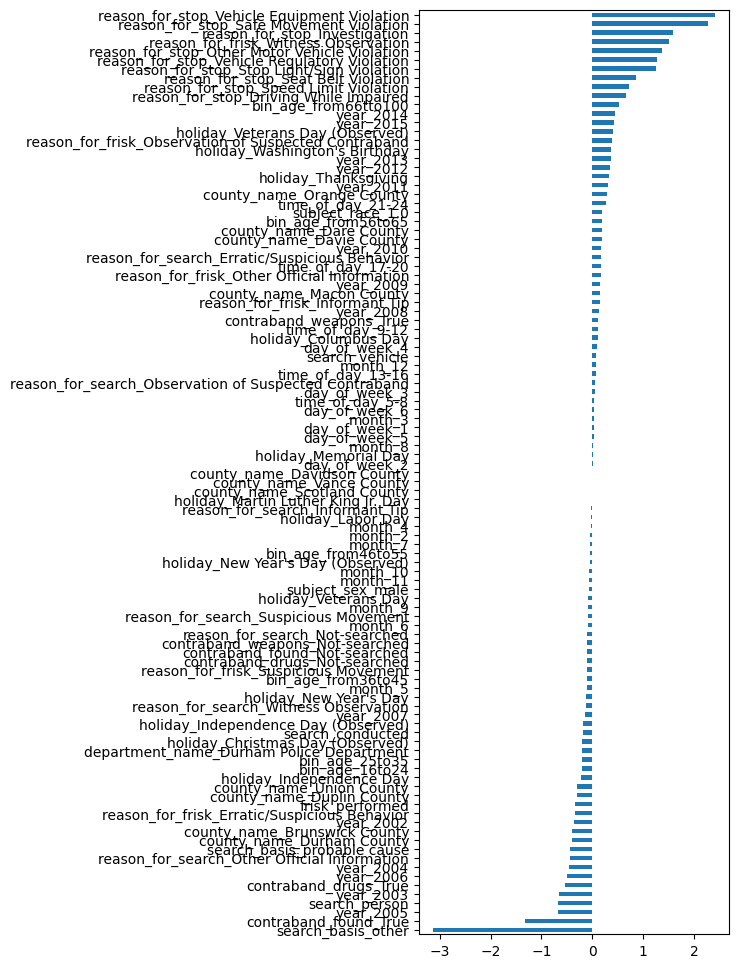

In [ ]:
coef_series = pd.Series(data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0], index=X.columns)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

In [ ]:
pd.set_option('display.max_rows', None)
# coef_series.sort_values()
coef_series.reindex(coef_series.abs().sort_values().index)

county_name_Davidson County                              0.000000
county_name_Vance County                                 0.000000
county_name_Scotland County                              0.000000
day_of_week_2                                            0.002963
holiday_Memorial Day                                     0.003363
month_8                                                  0.011859
holiday_Martin Luther King Jr. Day                      -0.014821
day_of_week_5                                            0.023493
day_of_week_1                                            0.026291
reason_for_search_Informant Tip                         -0.027518
holiday_Labor Day                                       -0.030260
month_3                                                  0.030516
month_4                                                 -0.030589
day_of_week_6                                            0.031177
time_of_day_5-8                                          0.035344
day_of_wee

In [ ]:
df_durham_old.reason_for_stop.value_counts()

Speed Limit Violation            108640
Vehicle Regulatory Violation      67409
Vehicle Equipment Violation       43267
Investigation                     25226
Safe Movement Violation           25113
Stop Light/Sign Violation         22647
Other Motor Vehicle Violation     15383
Seat Belt Violation               11311
Checkpoint                         5098
Driving While Impaired             1930
Name: reason_for_stop, dtype: int64

# Fairness assessment

## Fairness assessment with MetricFrame

In [ ]:
mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['subject_race'])

In [ ]:
mf1.by_group

subject_race
0.0    0.549764
1.0    0.361023
Name: false_negative_rate, dtype: float64

In [ ]:
Y_test[df_test['subject_race'] == 0].value_counts()

0    15806
1    13333
Name: target, dtype: int64

In [ ]:
Y_test[df_test['subject_race'] == 1].value_counts()

0    27745
1    26508
Name: target, dtype: int64

In [ ]:
df_test['outcome'].value_counts(normalize=True)

citation    0.533302
warning     0.441451
arrest      0.025247
Name: outcome, dtype: float64

In [ ]:
# from statsmodels.stats.proportion import test_proportions_2indep
# test_proportions_2indep(
#     count1 = 120272*0.215436
#     , nobs1 = 120272
#     , count2 = 178352*0.253596
#     , nobs2 = 178352
#     , value=0
#     , method=None
#     , compare='diff'
#     , alternative='smaller'
#     , correction=True
#     , return_results=True)

In [ ]:
print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.189
ratio: 0.657
max across groups: 0.55


In [ ]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['subject_race'])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,balanced_accuracy
subject_race,,,
0.0,0.295480,0.549764,0.642649
1.0,0.479328,0.361023,0.656090


In [ ]:
# You'll probably want to view them transposed:

pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,balanced_accuracy
difference,0.183848,0.188741,0.01344
ratio,0.616447,0.656688,0.979515
group_min,0.29548,0.361023,0.642649
group_max,0.479328,0.549764,0.65609


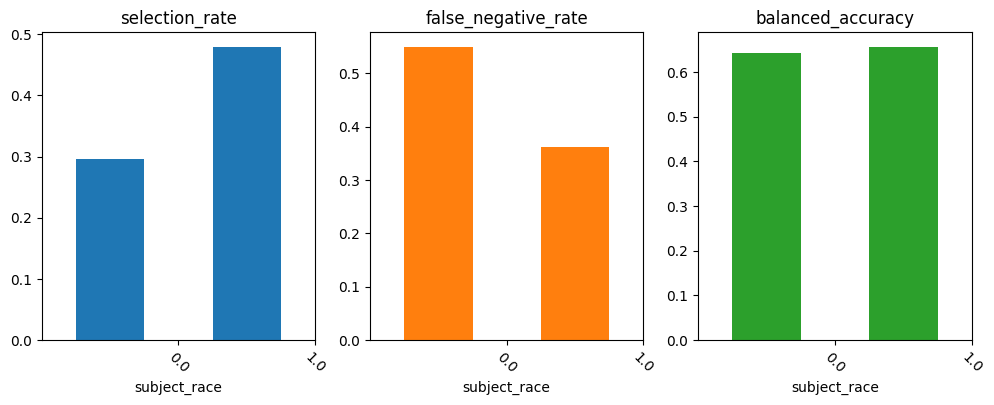

In [ ]:
# You can also easily plot all of the metrics using DataFrame plotting capabilities

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);

# Hyperparameter Tuning

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create the pipeline
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
    ('preprocessing', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])

# Define the parameter grid for GridSearchCV
parameters = {
    'logistic_regression__penalty': ['l1', 'l2'],
    'logistic_regression__C': [0.01, 0.1, 1, 10, 100, 1000],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__max_iter': [1000]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=5, verbose=0)

# Fit the grid search to your data
grid_search.fit(X_train_bal, Y_train_bal)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [ ]:

'''


parameters = [{'penalty':['l1','l2']},
              {'C':[0.01, 0.1, 1, 10, 100, 1000]},
              {'solver':['saga']},
              {'max_iter':[500, 1000, 5000, 10000]}]
logreg = LogisticRegression()
grid_search = GridSearchCV(estimator = logreg,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

In [ ]:
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

In [ ]:
reason_for_stop = 'reason_for_stop_Speed Limit Violation'

In [ ]:
X_test_speeding = X_test[X_test[reason_for_stop] == True]

In [ ]:
Y_test_speeding = Y_test[X_test[reason_for_stop] == True]

In [ ]:
Y_pred_proba_speed = unmitigated_pipeline.predict_proba(X_test_speeding)[:,1]
Y_pred_speed = unmitigated_pipeline.predict(X_test_speeding)

In [ ]:
RocCurveDisplay.from_estimator(unmitigated_pipeline, X_test_speeding, Y_test_speeding);

In [ ]:
df_test_speeding = df_test[X_test[reason_for_stop] == True]

In [ ]:
mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test_speeding,
                  y_pred=Y_pred_speed,
                  sensitive_features=df_test_speeding['subject_race'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

We'll create a HistGradientBoostingClassifier and fit it to the balanced training data set.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
clf = HistGradientBoostingClassifier()

# Fit the model to the training data
clf.fit(X_train, Y_train)

In [ ]:
exercise_pred = clf.predict(X_test)

In [ ]:
from fairlearn.metrics import false_positive_rate
# Define exercise fairness metrics of interest here
exercise_metrics = {
    "count": count,
    "false_positive_rate": false_positive_rate,
    "recall_score": recall_score
}

In [ ]:
metricframe_unmitigated = MetricFrame(metrics=exercise_metrics,
                  y_true=Y_test,
                  y_pred=exercise_pred,
                  sensitive_features=df_test['subject_race'])

In [ ]:
metricframe_unmitigated.by_group

In [ ]:
RocCurveDisplay.from_estimator(clf, X_test, Y_test);